In [1]:
import argparse

index=1
update = True

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152

os.environ["CUDA_VISIBLE_DEVICES"]='5'

from importlib.machinery import SourceFileLoader
import uproot as up
import numpy as np
import time
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
tf.get_logger().setLevel('INFO')

time1 = time.time()

sys.path.append('/software/pc24403/tfpcbpggsz/func')
sys.path.append('/software/pc24403/tfpcbpggsz/amp_ampgen_test')
sys.path.append('/software/pc24403/tfpcbpggsz/core')
from amp import *
from core_test_mine import *
from tfmassshape import *

mc_path = '/shared/scratch/pc24403/amp_ampgen_noeff/'



def get_mass(p1,p2):
    return ((p1[:,0]+p2[:,0])**2 - (p1[:,1]+p2[:,1])**2 - (p1[:,2]+p2[:,2])**2 - (p1[:,3]+p2[:,3])**2)


def get_p4(decay="b2dpi", cut='', index=index):

    file_name = ''
    branch_names = []
    if cut == 'int':
        file_name = f'/software/pc24403/PCBPGGSZ/Int/weighted_{decay}.root:DalitzEventList'
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz"]
    elif cut == 'int_noeff':
        file_name = f'/software/pc24403/PCBPGGSZ/Int/flat_{decay}.root:DalitzEventList'
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz"]        
    elif decay.split('_')[0] == 'b2dk' or decay.split('_')[0] == 'b2dpi':
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz"]
        if cut == 'p':
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/1x/{decay}_{index}.root:DalitzEventList'
        else:
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/1x/{decay}_{index}.root:DalitzEventList'

    tree = up.open(file_name)
    charge = '_1_K0S0_E>0'
    if cut == 'p':
        charge = '(Bac_ID>0) & (B_M> 5080)'
    if cut == 'm':
        charge = '(Bac_ID<0)& (B_M> 5080)'
       
    array = tree.arrays(branch_names, charge)
    _p1 = np.asarray([array["_1_K0S0_E"], array["_1_K0S0_Px"], array["_1_K0S0_Py"], array["_1_K0S0_Pz"]])
    _p2 = np.asarray([array["_2_pi#_E"], array["_2_pi#_Px"], array["_2_pi#_Py"], array["_2_pi#_Pz"]])
    _p3 = np.asarray([array["_3_pi~_E"], array["_3_pi~_Px"], array["_3_pi~_Py"], array["_3_pi~_Pz"]])
    
    # convert 4*1000 into a vectot<double>
    p1 = np.transpose(_p1)
    p2 = np.transpose(_p2)
    p3 = np.transpose(_p3)

    p1bar = np.hstack((p1[:, :1], np.negative(p1[:, 1:])))
    p2bar = np.hstack((p2[:, :1], np.negative(p2[:, 1:])))
    p3bar = np.hstack((p3[:, :1], np.negative(p3[:, 1:])))



    return p1, p2, p3, p1bar, p2bar, p3bar

def load_int_amp(args):
    p1, p2, p3 = args

    return Kspipi.AMP(p1.tolist(), p2.tolist(), p3.tolist())

def getAmp(decay='b2dpi', cut='int', index=index):

    start_time = time.time()
    p1, p2, p3, p1bar, p2bar, p3bar = get_p4(decay=decay, cut=cut, index=index)
    amplitude = []
    amplitudeBar = []

    p1_np = np.array(p1)
    p2_np = np.array(p2)
    p3_np = np.array(p3)
    p1bar_np = np.array(p1bar)
    p2bar_np = np.array(p2bar)
    p3bar_np = np.array(p3bar)

    data = [(p1_np[i], p2_np[i], p3_np[i]) for i in range(len(p1_np))]
    with Pool(processes=multiprocessing.cpu_count()) as pool:
        amplitude.append(pool.map(load_int_amp, data))
    data_bar = [(p1bar_np[i], p3bar_np[i], p2bar_np[i]) for i in range(len(p1bar_np))]
    with Pool(processes=multiprocessing.cpu_count()) as pool:
        amplitudeBar.append(pool.map(load_int_amp, data_bar))
    
    end_time = time.time()
    print(f'Amplitude for {decay} loaded in {end_time-start_time} seconds')
    amplitude = np.array(amplitude)
    amplitudeBar = np.negative(np.array(amplitudeBar))

    return amplitude, amplitudeBar
    
def get_p4_v2(decay="b2dpi", cut='', index=index, comp='sig'):

    file_name = ''
    branch_names = []
    if cut == 'int':
        file_name = f'/software/pc24403/PCBPGGSZ/Int/weighted_{decay}.root:DalitzEventList'
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz"]
    elif cut == 'int_noeff':
        file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/root/weighted_noeff.root:DalitzEventList'
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz"]      
    elif decay.split('_')[0] == 'b2dk' or decay.split('_')[0] == 'b2dpi':
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz", "B_M"]
        if cut == 'p':
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/1x/{decay}_{index}.root:DalitzEventList'
        else:
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/1x/{decay}_{index}.root:DalitzEventList'

    tree = up.open(file_name)
  # Load the branches as arrays
    charge = '(Bac_ID>0)& (B_M> 5080)'
    if cut == 'm':
        charge = '(Bac_ID<0)& (B_M> 5080)'
    
    array = tree.arrays(branch_names, charge)
       

    _p1 = np.asarray([array["_1_K0S0_E"], array["_1_K0S0_Px"], array["_1_K0S0_Py"], array["_1_K0S0_Pz"]])
    _p2 = np.asarray([array["_2_pi#_E"], array["_2_pi#_Px"], array["_2_pi#_Py"], array["_2_pi#_Pz"]])
    _p3 = np.asarray([array["_3_pi~_E"], array["_3_pi~_Px"], array["_3_pi~_Py"], array["_3_pi~_Pz"]])
    
    # convert 4*1000 into a vectot<double>
    p1 = np.transpose(_p1)
    p2 = np.transpose(_p2)
    p3 = np.transpose(_p3)

    p1bar = np.hstack((p1[:, :1], np.negative(p1[:, 1:])))
    p2bar = np.hstack((p2[:, :1], np.negative(p2[:, 1:])))
    p3bar = np.hstack((p3[:, :1], np.negative(p3[:, 1:])))

    B_M = np.zeros(len(p1))
    if cut != 'int':
        
        B_M = np.asarray([array["B_M"]])


    return p1, p2, p3, p1bar, p2bar, p3bar, B_M


def getMass(decay='b2dpi', cut='int', index=index):

    start_time = time.time()
    p1, p2, p3, p1bar, p2bar, p3bar = get_p4(decay=decay, cut=cut, index=index)
    amplitude = []
    amplitudeBar = []

    p1_np = np.array(p1)
    p2_np = np.array(p2)
    p3_np = np.array(p3)
    p1bar_np = np.array(p1bar)
    p2bar_np = np.array(p2bar)
    p3bar_np = np.array(p3bar)

    s12 = get_mass(p1_np, p2_np)
    s13 = get_mass(p1_np, p3_np)

    return s12, s13

def getMass_v2(decay='b2dpi', cut='int', comp='sig', index=index):

    start_time = time.time()
    p1, p2, p3, p1bar, p2bar, p3bar, B_M = get_p4_v2(decay=decay, cut=cut, comp=comp, index=index)
    amplitude = []
    amplitudeBar = []

    p1_np = np.array(p1)
    p2_np = np.array(p2)
    p3_np = np.array(p3)
    p1bar_np = np.array(p1bar)
    p2bar_np = np.array(p2bar)
    p3bar_np = np.array(p3bar)

    s12 = get_mass(p1_np, p2_np)
    s13 = get_mass(p1_np, p3_np)

    return s12, s13, B_M



def scanner(m, scan_range=1, size=50):
    pts = {}
    for i in range(0, 6):
        for j in range(i + 1, 6):
            a = m.parameters[i]
            b = m.parameters[j]
            a_err = m.errors[i]
            b_err = m.errors[j]
            a_val = m.values[i]
            b_val = m.values[j]
            x0, x1 = i, j  # Assign x0 and x1 for key naming
            pts[f"{x0}_{x1}"] = m.contour(
                a, b,
                bound=[
                    [a_val - scan_range * a_err, a_val + scan_range * a_err],
                    [b_val - scan_range * b_err, b_val + scan_range * b_err]
                ],
                size=size
            )
    return pts


#config_mass_shape_output = SourceFileLoader('config_mass_shape_output', '/software/pc24403/PCBPGGSZ/outputs/toy/mass_fit/config/lhcb/1x/%s'%(f'config_cpfit_output_{index}.py')).load_module()
#config_mass_shape_output = SourceFileLoader('config_mass_shape_output', '/software/pc24403/PCBPGGSZ/mass_fit/config/%s'%(f'config_CPrange_input_All.py')).load_module()
#varDict = config_mass_shape_output.getconfig()
config_mass_shape_output = SourceFileLoader('config_mass_shape_output', '/software/pc24403/PCBPGGSZ/outputs/toy/mass_fit/config/%s'%('config_mass_shape_output_1.py')).load_module()
varDict = config_mass_shape_output.getconfig()
print_yields = True
sig_yield = {}
Bdecays = ['b2dk', 'b2dpi']
Types = ['LL', 'DD']
for bdecay in Bdecays:
    for Type in Types:
        decay = ''

        if bdecay == 'b2dk':
            decay = 'DK_KsPiPi_%s'%Type
        elif bdecay == 'b2dpi':
            decay = 'DPi_KsPiPi_%s'%Type

        #print yields
        if print_yields == True:
            print('Yields:')
            print('Sig: %.2f'%varDict['n_sig_%s'%decay])
            print('MisID: %.2f'%varDict['n_misid_%s'%decay])
            print('Low: %.2f'%varDict['n_low_%s'%decay])
            print('Comb: %.2f'%varDict['n_comb_%s'%decay])
            if bdecay == 'b2dk':
                print('Low MisID: %.2f'%varDict['n_low_misID_%s'%decay])
                print('Low Bs2DKPi: %.2f'%varDict['n_low_Bs2DKPi_%s'%decay])
                sum_yields = varDict['n_sig_%s'%decay] + varDict['n_misid_%s'%decay] + varDict['n_low_%s'%decay] + varDict['n_comb_%s'%decay] + varDict['n_low_misID_%s'%decay] + varDict['n_low_Bs2DKPi_%s'%decay]
            else:
                sum_yields = varDict['n_sig_%s'%decay] + varDict['n_misid_%s'%decay] + varDict['n_low_%s'%decay] + varDict['n_comb_%s'%decay]
            print('Sum: %.2f'%sum_yields)



pdfs_data = {}
s12_data = {}
s13_data = {}
Bu_M = {}
mass_pdfs = {}
pdfs_mc = {}
s12_mc = {}
s13_mc = {}
Bu_M_mc = {}

for decay in ['b2dk_LL', 'b2dk_DD', 'b2dpi_LL', 'b2dpi_DD']:
    for charge in ['p', 'm']:
        new_decay = decay + '_'+ charge
        print('--- INFO: Preparing pdfs for %s...'%new_decay)
        s12_mc[new_decay], s13_mc[new_decay] = getMass(new_decay, 'int_noeff')
        s12_mc[new_decay] = tf.cast(s12_mc[new_decay][:100000], tf.float64)
        s13_mc[new_decay] = tf.cast(s13_mc[new_decay][:100000], tf.float64)
        Bu_M_mc[new_decay] = tf.linspace(5080.0, 5800.0,s12_mc[new_decay].shape[0])
        Bu_M_mc[new_decay] = tf.cast(Bu_M_mc[new_decay], tf.float64)
        pdfs_mc[new_decay] = preparePdf_data(Bu_M_mc[new_decay], varDict, decay)
        s12_data[new_decay], s13_data[new_decay], Bu_M[new_decay] = getMass_v2(decay, charge, index)
        Bu_M[new_decay] = tf.cast(Bu_M[new_decay], tf.float64)

comps = ['sig', 'misid', 'comb', 'low', 'low_misID', 'low_Bs2DKPi']
for decay in ['b2dk_LL', 'b2dk_DD', 'b2dpi_LL', 'b2dpi_DD']:
    for charge in ['p', 'm']:
        new_decay = decay + '_'+ charge
        mass_pdfs[new_decay] = {}
        for comp in comps:
            if decay.split('_')[0] == 'b2dpi' and (comp == 'low_Bs2DKPi' or comp == 'low_misID'): continue
            mass_pdfs[new_decay][comp] = pdfs_mc[new_decay][comp](Bu_M_mc[new_decay])
time2 = time.time()
 
print('INFO: mass Function loaded...')

if update == True:
    print('INFO: Updating Log...')
    comp_tag = {'sig': 1, 'comb': 2, 'misid': 3, 'low': 4, 'low_misID': 5, 'low_Bs2DKPi': 6}
    for decay in ['DK_KsPiPi_LL', 'DK_KsPiPi_DD', 'DPi_KsPiPi_LL', 'DPi_KsPiPi_DD']:
        new_decay = decay
        if decay.split('_')[0] == 'DK':
            new_decay = 'b2dk_'+decay.split('_')[2]
        elif decay.split('_')[0] == 'DPi':
            new_decay = 'b2dpi_'+decay.split('_')[2]
        file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/1x/{new_decay}_{index}.root:DalitzEventList'
        tree = up.open(file_name)
        for comp in comp_tag:
            array = tree.arrays('tagmode','(B_M>5080) & (tagmode==%d)'%comp_tag[comp])
            varDict[f'n_{comp}_{decay}'] = len(array)
            


2024-06-23 10:15:51.149118: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-23 10:15:52.287732: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


D0ToKSpipi2018 (Apr 30 2024) ==> Initialization !


2024-06-23 10:15:53.691153: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-06-23 10:15:53.691215: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: hm01.dice.priv
2024-06-23 10:15:53.691224: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: hm01.dice.priv
2024-06-23 10:15:53.691360: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 550.54.15
2024-06-23 10:15:53.691425: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 525.85.12
2024-06-23 10:15:53.691433: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:251] kernel version 525.85.12 does not match DSO version 550.54.15 -- cannot find working devices in this configuration


Yields:
Sig: 4069.98
MisID: 1830.69
Low: 2536.03
Comb: 1903.34
Low MisID: 2286.31
Low Bs2DKPi: 232.35
Sum: 12858.69
Yields:
Sig: 9430.93
MisID: 4058.41
Low: 5667.36
Comb: 3894.70
Low MisID: 4994.03
Low Bs2DKPi: 526.33
Sum: 28571.77
Yields:
Sig: 61514.99
MisID: 622.18
Low: 42812.99
Comb: 3701.43
Sum: 108651.59
Yields:
Sig: 139348.43
MisID: 1421.69
Low: 95558.80
Comb: 9668.12
Sum: 245997.04
--- INFO: Preparing pdfs for b2dk_LL_p...
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...
--- INFO: Preparing pdfs for b2dk_LL_m...
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...
--- INFO: Preparing pdfs for b2dk_DD_p...
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...
--- INFO: Prep

In [2]:
eff={}
eff_misid={}
eff_low={}
print('INFO: Calculate efficiency...')
for decay in ['b2dk_LL', 'b2dk_DD', 'b2dpi_LL', 'b2dpi_DD']:
    for charge in ['p', 'm']:
        new_decay = decay + '_'+ charge
        eff[new_decay] = eff_fun(dalitz_transform(s12_mc[new_decay], s13_mc[new_decay]), charge, decay)
        eff_low[new_decay] = eff_fun(dalitz_transform(s12_mc[new_decay], s13_mc[new_decay]), charge, decay.replace('dk', 'dpi'))

        if decay.split('_')[0] == 'b2dpi':
            eff_misid[new_decay] = eff_fun(dalitz_transform(s12_mc[new_decay], s13_mc[new_decay]), charge, decay.replace('dpi', 'dk'))
        elif decay.split('_')[0] == 'b2dk':
            eff_misid[new_decay] = eff_fun(dalitz_transform(s12_mc[new_decay], s13_mc[new_decay]), charge, decay.replace('dk', 'dpi'))          



     

INFO: Calculate efficiency...


In [3]:
logpath = '/dice/users/pc24403/BPGGSZ/sim_fit_check_each'
if os.path.exists(logpath) == False:
    os.mkdir(logpath)

def prod_comb(amp=[], ampbar=[], normA=1.2, normAbar=1.2, fracDD=0.82, eff1=[], eff2=[]):

    absA = tf.cast(tf.abs(amp), tf.float64)
    absAbar = tf.cast(tf.abs(ampbar), tf.float64)
    frac1 = fracDD/2.0
    frac2 = 1.0 - fracDD
    prob1 = eff1*absA**2 /normA
    prob2 = eff2*absAbar**2 /normAbar 
    prob3 = tf.ones_like(absA)
    #return ((absA**2/normA + absAbar**2/normAbar)*0.5 * fracDD + 1*(1.0-fracDD))
    return prob1 * frac1 + prob2 * frac1 + prob3 * frac2

print('INFO: Initialize the amplitudes...')

amp_Data__dk_dd_m = []
ampbar_Data_dk_dd_m = []
amp_Data_dk_dd_p = []
ampbar_Data_dk_dd_p = []
amp_Data_dk_ll_m = []
ampbar_Data_dk_ll_m = []
amp_Data_dk_ll_p = []
ampbar_Data_dk_ll_p = []
amp_dk_ll_p = []
amp_dk_ll_m = []
amp_dk_dd_p = []
amp_dk_dd_m = []
ampbar_dk_ll_p = []
ampbar_dk_ll_m = []
ampbar_dk_dd_p = []
ampbar_dk_dd_m = []

amp_Data_dpi_dd_m = []
ampbar_Data_dpi_dd_m = []
amp_Data_dpi_dd_p = []
ampbar_Data_dpi_dd_p = []
amp_Data_dpi_ll_m = []
ampbar_Data_dpi_ll_m = []
amp_Data_dpi_ll_p = []
ampbar_Data_dpi_ll_p = []
amp_dpi_ll_p = []
amp_dpi_ll_m = []
amp_dpi_dd_p = []
amp_dpi_dd_m = []
ampbar_dpi_ll_p = []
ampbar_dpi_ll_m = []
ampbar_dpi_dd_p = []
ampbar_dpi_dd_m = []


print('INFO: Loading amplitudes...')


amp_dk_dd_p = np.load(mc_path + '/Int_b2dk_DD_p_amp.npy')
amp_dk_dd_p= amp_dk_dd_p[:,:100000]
ampbar_dk_dd_p = np.load(mc_path + '/Int_b2dk_DD_p_ampbar.npy')
ampbar_dk_dd_p = ampbar_dk_dd_p[:,:100000]
amp_dk_dd_m = np.load(mc_path + '/Int_b2dk_DD_m_amp.npy')
amp_dk_dd_m = amp_dk_dd_m[:,:100000]
ampbar_dk_dd_m = np.load(mc_path + '/Int_b2dk_DD_m_ampbar.npy')
ampbar_dk_dd_m = ampbar_dk_dd_m[:,:100000]
amp_dk_ll_p = np.load(mc_path + '/Int_b2dk_LL_p_amp.npy')
amp_dk_ll_p = amp_dk_ll_p[:,:100000]
ampbar_dk_ll_p = np.load(mc_path + '/Int_b2dk_LL_p_ampbar.npy')
ampbar_dk_ll_p = ampbar_dk_ll_p[:,:100000]
amp_dk_ll_m = np.load(mc_path + '/Int_b2dk_LL_m_amp.npy')
amp_dk_ll_m = amp_dk_ll_m[:,:100000]
ampbar_dk_ll_m = np.load(mc_path + '/Int_b2dk_LL_m_ampbar.npy')
ampbar_dk_ll_m = ampbar_dk_ll_m[:,:100000]


amp_dpi_dd_p = np.load(mc_path + '/Int_b2dpi_DD_p_amp.npy')
amp_dpi_dd_p = amp_dpi_dd_p[:,:100000]
ampbar_dpi_dd_p = np.load(mc_path + '/Int_b2dpi_DD_p_ampbar.npy')
ampbar_dpi_dd_p = ampbar_dpi_dd_p[:,:100000]
amp_dpi_dd_m = np.load(mc_path + '/Int_b2dpi_DD_m_amp.npy')
amp_dpi_dd_m = amp_dpi_dd_m[:,:100000]
ampbar_dpi_dd_m = np.load(mc_path + '/Int_b2dpi_DD_m_ampbar.npy')
ampbar_dpi_dd_m = ampbar_dpi_dd_m[:,:100000]
amp_dpi_ll_p = np.load(mc_path + '/Int_b2dpi_LL_p_amp.npy')
amp_dpi_ll_p = amp_dpi_ll_p[:,:100000]
ampbar_dpi_ll_p = np.load(mc_path + '/Int_b2dpi_LL_p_ampbar.npy')
ampbar_dpi_ll_p = ampbar_dpi_ll_p[:,:100000]
amp_dpi_ll_m = np.load(mc_path + '/Int_b2dpi_LL_m_amp.npy')
amp_dpi_ll_m = amp_dpi_ll_m[:,:100000]
ampbar_dpi_ll_m = np.load(mc_path + '/Int_b2dpi_LL_m_ampbar.npy')
ampbar_dpi_ll_m = ampbar_dpi_ll_m[:,:100000]

'''
amp_Data_dk_dd_p, ampbar_Data_dk_dd_p = getAmp('b2dk_DD', 'p', index=index)
amp_Data_dk_dd_m, ampbar_Data_dk_dd_m = getAmp('b2dk_DD', 'm', index=index)
amp_Data_dk_ll_p, ampbar_Data_dk_ll_p = getAmp('b2dk_LL', 'p', index=index)
amp_Data_dk_ll_m, ampbar_Data_dk_ll_m = getAmp('b2dk_LL', 'm', index=index)
amp_Data_dpi_dd_p, ampbar_Data_dpi_dd_p = getAmp('b2dpi_DD', 'p', index=index)
amp_Data_dpi_dd_m, ampbar_Data_dpi_dd_m = getAmp('b2dpi_DD', 'm', index=index)
amp_Data_dpi_ll_p, ampbar_Data_dpi_ll_p = getAmp('b2dpi_LL', 'p', index=index)
amp_Data_dpi_ll_m, ampbar_Data_dpi_ll_m = getAmp('b2dpi_LL', 'm', index=index)
#Post to TF constant
amp_Data_dk_dd_p = tf.constant(amp_Data_dk_dd_p, dtype=tf.complex128)
ampbar_Data_dk_dd_p = tf.constant(ampbar_Data_dk_dd_p, dtype=tf.complex128)
amp_Data_dk_dd_m = tf.constant(amp_Data_dk_dd_m, dtype=tf.complex128)
ampbar_Data_dk_dd_m = tf.constant(ampbar_Data_dk_dd_m, dtype=tf.complex128)
amp_Data_dk_ll_p = tf.constant(amp_Data_dk_ll_p, dtype=tf.complex128)
ampbar_Data_dk_ll_p = tf.constant(ampbar_Data_dk_ll_p, dtype=tf.complex128)
amp_Data_dk_ll_m = tf.constant(amp_Data_dk_ll_m, dtype=tf.complex128)
ampbar_Data_dk_ll_m = tf.constant(ampbar_Data_dk_ll_m, dtype=tf.complex128)
'''
amp_dk_dd_p = tf.constant(amp_dk_dd_p, dtype=tf.complex128)
ampbar_dk_dd_p = tf.constant(ampbar_dk_dd_p, dtype=tf.complex128)
amp_dk_dd_m = tf.constant(amp_dk_dd_m, dtype=tf.complex128)
ampbar_dk_dd_m = tf.constant(ampbar_dk_dd_m, dtype=tf.complex128)
amp_dk_ll_p = tf.constant(amp_dk_ll_p, dtype=tf.complex128)
ampbar_dk_ll_p = tf.constant(ampbar_dk_ll_p, dtype=tf.complex128)
amp_dk_ll_m = tf.constant(amp_dk_ll_m, dtype=tf.complex128)
ampbar_dk_ll_m = tf.constant(ampbar_dk_ll_m, dtype=tf.complex128)
amp_dpi_dd_p = tf.constant(amp_dpi_dd_p, dtype=tf.complex128)
ampbar_dpi_dd_p = tf.constant(ampbar_dpi_dd_p, dtype=tf.complex128)
amp_dpi_dd_m = tf.constant(amp_dpi_dd_m, dtype=tf.complex128)
ampbar_dpi_dd_m = tf.constant(ampbar_dpi_dd_m, dtype=tf.complex128)
amp_dpi_ll_p = tf.constant(amp_dpi_ll_p, dtype=tf.complex128)
ampbar_dpi_ll_p = tf.constant(ampbar_dpi_ll_p, dtype=tf.complex128)
amp_dpi_ll_m = tf.constant(amp_dpi_ll_m, dtype=tf.complex128)
ampbar_dpi_ll_m = tf.constant(ampbar_dpi_ll_m, dtype=tf.complex128)

time3 = time.time()


def prod_nll_dk_dd(x, Bsign=1):

    decay = 'b2dk_DD'
    fracDD = 0.53

    nsig = x[6]*0.5
    nmisid = varDict['n_misid_DK_KsPiPi_DD']*0.5
    ncomb = x[7]*0.5
    nlow = x[8]*0.5
    nlow_misID = varDict['n_low_misID_DK_KsPiPi_DD']*0.5
    nlow_Bs2DKPi = varDict['n_low_Bs2DKPi_DK_KsPiPi_DD']*0.5



    normalisationCrossTerms_p = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_dd_p, ampbar_dk_dd_p)
    normalisationCrossTerms_m = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_dd_m, ampbar_dk_dd_m)
    misid_normalisationCrossTerms_p = totalAmplitudeSquared_Integrated_crossTerm(amp_dpi_dd_p, ampbar_dpi_dd_p)
    misid_normalisationCrossTerms_m = totalAmplitudeSquared_Integrated_crossTerm(amp_dpi_dd_m, ampbar_dpi_dd_m)

    normA_p = tf.math.reduce_mean(tf.math.abs(amp_dk_dd_p)**2)
    normAbar_p = tf.math.reduce_mean(tf.math.abs(ampbar_dk_dd_p)**2)
    normA_m = tf.math.reduce_mean(tf.math.abs(amp_dk_dd_m)**2)
    normAbar_m = tf.math.reduce_mean(tf.math.abs(ampbar_dk_dd_m)**2)

    misid_normA_p = tf.math.reduce_mean(tf.math.abs(amp_dpi_dd_p)**2)
    misid_normAbar_p = tf.math.reduce_mean(tf.math.abs(ampbar_dpi_dd_p)**2)
    misid_normA_m = tf.math.reduce_mean(tf.math.abs(amp_dpi_dd_m)**2)
    misid_normAbar_m = tf.math.reduce_mean(tf.math.abs(ampbar_dpi_dd_m)**2)


    sig_prob_p = eff[decay+'_p']* nsig * mass_pdfs[decay+'_p']['sig'] * prod_totalAmplitudeSquared_XY(1, amp_dk_dd_p, ampbar_dk_dd_p, x, mass_pdfs[decay+'_p']['sig'], mass_pdfs[decay+'_m']['sig'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    sig_prob_m = eff[decay+'_m']* nsig * mass_pdfs[decay+'_m']['sig'] * prod_totalAmplitudeSquared_XY(-1, amp_dk_dd_m, ampbar_dk_dd_m, x, mass_pdfs[decay+'_p']['sig'], mass_pdfs[decay+'_m']['sig'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    misid_prob_p = eff_misid[decay+'_p'] * nmisid * mass_pdfs[decay+'_p']['misid'] * prod_totalAmplitudeSquared_DPi_XY(1, amp_dk_dd_p, ampbar_dk_dd_p, x, mass_pdfs[decay+'_p']['misid'], mass_pdfs[decay+'_m']['misid'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    misid_prob_m = eff_misid[decay+'_m'] * nmisid * mass_pdfs[decay+'_m']['misid'] * prod_totalAmplitudeSquared_DPi_XY(-1, amp_dk_dd_m, ampbar_dk_dd_m, x, mass_pdfs[decay+'_p']['misid'], mass_pdfs[decay+'_m']['misid'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    comb_prob_p = ncomb * mass_pdfs[decay+'_p']['comb'] * prod_comb(amp_dk_dd_p, ampbar_dk_dd_p, misid_normA_m, misid_normAbar_p, fracDD=fracDD, eff1=eff_low[decay+'_m'], eff2=eff_low[decay+'_p'])
    comb_prob_m = ncomb * mass_pdfs[decay+'_m']['comb'] * prod_comb(amp_dk_dd_m, ampbar_dk_dd_m, misid_normA_m, misid_normAbar_p, fracDD=fracDD, eff1=eff_low[decay+'_m'], eff2=eff_low[decay+'_p'])
    low_prob_p = eff_low[decay+'_p'] * nlow * mass_pdfs[decay+'_p']['low'] * prod_low(1, amp_dk_dd_p, ampbar_dk_dd_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], type='low')
    low_prob_m = eff_low[decay+'_m'] * nlow * mass_pdfs[decay+'_m']['low'] * prod_low(-1, amp_dk_dd_m, ampbar_dk_dd_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], type='low')
    low_misID_prob_p =  eff_low[decay+'_p'] * nlow_misID * mass_pdfs[decay+'_p']['low_misID'] * prod_low(1, amp_dk_dd_p, ampbar_dk_dd_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], type='low_misID')
    low_misID_prob_m =  eff_low[decay+'_m'] * nlow_misID * mass_pdfs[decay+'_m']['low_misID'] * prod_low(-1, amp_dk_dd_m, ampbar_dk_dd_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], type='low_misID')
    low_Bs2DKPi_prob_p = eff_low[decay+'_p'] * nlow_Bs2DKPi * mass_pdfs[decay+'_p']['low_Bs2DKPi'] * prod_low(1, amp_dk_dd_p, ampbar_dk_dd_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], type='low_Bs2DKPi')
    low_Bs2DKPi_prob_m = eff_low[decay+'_m'] * nlow_Bs2DKPi * mass_pdfs[decay+'_m']['low_Bs2DKPi'] * prod_low(-1, amp_dk_dd_m, ampbar_dk_dd_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], type='low_Bs2DKPi')



    total_yield = (nsig + nmisid + ncomb + nlow + nlow_misID + nlow_Bs2DKPi)
    
    normalisation_Bplus = totalAmplitudeSquared_Integrated(1, normA_p, normAbar_p, normalisationCrossTerms_p, x)
    normalisation_Bminus = totalAmplitudeSquared_Integrated(-1, normA_m, normAbar_m, normalisationCrossTerms_m, x)
    misid_normalisation_Bplus = totalAmplitudeSquared_DPi_Integrated(1, misid_normA_p, misid_normAbar_p, misid_normalisationCrossTerms_p, x)
    misid_normalisation_Bminus = totalAmplitudeSquared_DPi_Integrated(-1, misid_normA_m, misid_normAbar_m, misid_normalisationCrossTerms_m, x) 


    low_normalisation_Bplus = tf.cast(misid_normAbar_p, tf.float64)
    low_normalisation_Bminus = tf.cast(misid_normA_m, tf.float64)


    prob_p = {}
    prob_m = {}
    prob_p['total'] = (1/total_yield*((sig_prob_p/normalisation_Bplus)+(misid_prob_p/misid_normalisation_Bplus)+(comb_prob_p)+(low_prob_p/low_normalisation_Bplus)+(low_misID_prob_p/low_normalisation_Bplus)+(low_Bs2DKPi_prob_p/low_normalisation_Bplus)))
    prob_m['total'] = (1/total_yield*((sig_prob_m/normalisation_Bminus)+(misid_prob_m/misid_normalisation_Bminus)+(comb_prob_m)+(low_prob_m/low_normalisation_Bminus)+(low_misID_prob_m/low_normalisation_Bminus)+(low_Bs2DKPi_prob_m/low_normalisation_Bminus)))
    prob_p['sig'] = (1/total_yield*((sig_prob_p/normalisation_Bplus)))
    prob_m['sig'] = (1/total_yield*((sig_prob_m/normalisation_Bminus)))
    prob_p['misid'] = (1/total_yield*((misid_prob_p/misid_normalisation_Bplus)))
    prob_m['misid'] = (1/total_yield*((misid_prob_m/misid_normalisation_Bminus)))
    prob_p['comb'] = (1/total_yield*((comb_prob_p)))
    prob_m['comb'] = (1/total_yield*((comb_prob_m)))
    prob_p['low'] = (1/total_yield*((low_prob_p/low_normalisation_Bplus)))
    prob_m['low'] = (1/total_yield*((low_prob_m/low_normalisation_Bminus)))
    prob_p['low_misID'] = (1/total_yield*((low_misID_prob_p/low_normalisation_Bplus)))
    prob_m['low_misID'] = (1/total_yield*((low_misID_prob_m/low_normalisation_Bminus)))
    prob_p['low_Bs2DKPi'] = (1/total_yield*((low_Bs2DKPi_prob_p/low_normalisation_Bplus)))
    prob_m['low_Bs2DKPi'] = (1/total_yield*((low_Bs2DKPi_prob_m/low_normalisation_Bminus)))
                            
    if Bsign ==1:
        return prob_p
    else:
        return prob_m



def prod_nll_dk_ll(x, Bsign=1):

    decay = 'b2dk_LL'
    fracDD = 0.86


    nsig = x[6]*0.5
    nmisid = varDict['n_misid_DK_KsPiPi_LL']*0.5
    ncomb = x[7]*0.5
    nlow = x[8]*0.5
    nlow_misID = varDict['n_low_misID_DK_KsPiPi_LL']*0.5
    nlow_Bs2DKPi = varDict['n_low_Bs2DKPi_DK_KsPiPi_LL']*0.5

    normalisationCrossTerms_p = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_ll_p, ampbar_dk_ll_p)
    normalisationCrossTerms_m = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_ll_m, ampbar_dk_ll_m)
    misid_normalisationCrossTerms_p = totalAmplitudeSquared_Integrated_crossTerm(amp_dpi_ll_p, ampbar_dpi_ll_p)
    misid_normalisationCrossTerms_m = totalAmplitudeSquared_Integrated_crossTerm(amp_dpi_ll_m, ampbar_dpi_ll_m)
    normA_p = tf.math.reduce_mean(tf.math.abs(amp_dk_ll_p)**2)
    normAbar_p = tf.math.reduce_mean(tf.math.abs(ampbar_dk_ll_p)**2)
    normA_m = tf.math.reduce_mean(tf.math.abs(amp_dk_ll_m)**2)
    normAbar_m = tf.math.reduce_mean(tf.math.abs(ampbar_dk_ll_m)**2)

    misid_normA_p = tf.math.reduce_mean(tf.math.abs(amp_dpi_ll_p)**2)
    misid_normAbar_p = tf.math.reduce_mean(tf.math.abs(ampbar_dpi_ll_p)**2)
    misid_normA_m = tf.math.reduce_mean(tf.math.abs(amp_dpi_ll_m)**2)
    misid_normAbar_m = tf.math.reduce_mean(tf.math.abs(ampbar_dpi_ll_m)**2)


    sig_prob_p = eff[decay+'_p'] * nsig * mass_pdfs[decay+'_p']['sig'] * prod_totalAmplitudeSquared_XY(1, amp_dk_ll_p, ampbar_dk_ll_p, x, mass_pdfs[decay+'_p']['sig'], mass_pdfs[decay+'_m']['sig'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    sig_prob_m = eff[decay+'_m'] *nsig * mass_pdfs[decay+'_m']['sig'] * prod_totalAmplitudeSquared_XY(-1, amp_dk_ll_m, ampbar_dk_ll_m, x, mass_pdfs[decay+'_p']['sig'], mass_pdfs[decay+'_m']['sig'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    misid_prob_p = eff_misid[decay+'_p'] *nmisid * mass_pdfs[decay+'_p']['misid'] * prod_totalAmplitudeSquared_DPi_XY(1, amp_dk_ll_p, ampbar_dk_ll_p, x, mass_pdfs[decay+'_p']['misid'], mass_pdfs[decay+'_m']['misid'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    misid_prob_m = eff_misid[decay+'_m'] *nmisid * mass_pdfs[decay+'_m']['misid'] * prod_totalAmplitudeSquared_DPi_XY(-1, amp_dk_ll_m, ampbar_dk_ll_m, x, mass_pdfs[decay+'_p']['misid'], mass_pdfs[decay+'_m']['misid'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    comb_prob_p = ncomb * mass_pdfs[decay+'_p']['comb'] * prod_comb(amp_dk_ll_p, ampbar_dk_ll_p, misid_normA_m, misid_normAbar_p, fracDD=fracDD, eff1=eff_low[decay+'_m'], eff2=eff_low[decay+'_p'])
    comb_prob_m = ncomb * mass_pdfs[decay+'_m']['comb'] * prod_comb(amp_dk_ll_m, ampbar_dk_ll_m, misid_normA_m, misid_normAbar_p, fracDD=fracDD, eff1=eff_low[decay+'_m'], eff2=eff_low[decay+'_p'])
    low_prob_p = eff_low[decay+'_p'] * nlow * mass_pdfs[decay+'_p']['low'] * prod_low(1, amp_dk_ll_p, ampbar_dk_ll_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], type='low')
    low_prob_m = eff_low[decay+'_m'] * nlow * mass_pdfs[decay+'_m']['low'] * prod_low(-1, amp_dk_ll_m, ampbar_dk_ll_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], type='low')
    low_misID_prob_p =  eff_low[decay+'_p'] *nlow_misID * mass_pdfs[decay+'_p']['low_misID'] * prod_low(1, amp_dk_ll_p, ampbar_dk_ll_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], type='low_misID')
    low_misID_prob_m =  eff_low[decay+'_m'] *nlow_misID * mass_pdfs[decay+'_m']['low_misID'] * prod_low(-1, amp_dk_ll_m, ampbar_dk_ll_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], type='low_misID')
    low_Bs2DKPi_prob_p = eff_low[decay+'_p'] *nlow_Bs2DKPi * mass_pdfs[decay+'_p']['low_Bs2DKPi'] * prod_low(1, amp_dk_ll_p, ampbar_dk_ll_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], type='low_Bs2DKPi')
    low_Bs2DKPi_prob_m = eff_low[decay+'_m'] *nlow_Bs2DKPi * mass_pdfs[decay+'_m']['low_Bs2DKPi'] * prod_low(-1, amp_dk_ll_m, ampbar_dk_ll_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], type='low_Bs2DKPi')



    total_yield = (nsig + nmisid + ncomb + nlow + nlow_misID + nlow_Bs2DKPi)*2

    
    normalisation_Bplus = totalAmplitudeSquared_Integrated(1, normA_p, normAbar_p, normalisationCrossTerms_p, x)
    normalisation_Bminus = totalAmplitudeSquared_Integrated(-1, normA_m, normAbar_m, normalisationCrossTerms_m, x)
    misid_normalisation_Bplus = totalAmplitudeSquared_DPi_Integrated(1, misid_normA_p, misid_normAbar_p, misid_normalisationCrossTerms_p, x)
    misid_normalisation_Bminus = totalAmplitudeSquared_DPi_Integrated(-1, misid_normA_m, misid_normAbar_m, misid_normalisationCrossTerms_m, x) 

    low_normalisation_Bplus = tf.cast(misid_normAbar_p, tf.float64)
    low_normalisation_Bminus = tf.cast(misid_normA_m, tf.float64)


    prob_p = {}
    prob_m = {}
    prob_p['total'] = (1/total_yield*((sig_prob_p/normalisation_Bplus)+(misid_prob_p/misid_normalisation_Bplus)+(comb_prob_p)+(low_prob_p/low_normalisation_Bplus)+(low_misID_prob_p/low_normalisation_Bplus)+(low_Bs2DKPi_prob_p/low_normalisation_Bplus)))
    prob_m['total'] = (1/total_yield*((sig_prob_m/normalisation_Bminus)+(misid_prob_m/misid_normalisation_Bminus)+(comb_prob_m)+(low_prob_m/low_normalisation_Bminus)+(low_misID_prob_m/low_normalisation_Bminus)+(low_Bs2DKPi_prob_m/low_normalisation_Bminus)))
    prob_p['sig'] = (1/total_yield*((sig_prob_p/normalisation_Bplus)))
    prob_m['sig'] = (1/total_yield*((sig_prob_m/normalisation_Bminus)))
    prob_p['misid'] = (1/total_yield*((misid_prob_p/misid_normalisation_Bplus)))
    prob_m['misid'] = (1/total_yield*((misid_prob_m/misid_normalisation_Bminus)))
    prob_p['comb'] = (1/total_yield*((comb_prob_p)))
    prob_m['comb'] = (1/total_yield*((comb_prob_m)))
    prob_p['low'] = (1/total_yield*((low_prob_p/low_normalisation_Bplus)))
    prob_m['low'] = (1/total_yield*((low_prob_m/low_normalisation_Bminus)))
    prob_p['low_misID'] = (1/total_yield*((low_misID_prob_p/low_normalisation_Bplus)))
    prob_m['low_misID'] = (1/total_yield*((low_misID_prob_m/low_normalisation_Bminus)))
    prob_p['low_Bs2DKPi'] = (1/total_yield*((low_Bs2DKPi_prob_p/low_normalisation_Bplus)))
    prob_m['low_Bs2DKPi'] = (1/total_yield*((low_Bs2DKPi_prob_m/low_normalisation_Bminus)))
                            
    if Bsign ==1:
        return prob_p
    else:
        return prob_m

def prod_nll_dpi_dd(x, Bsign):

    decay = 'b2dpi_DD'
    fracDD = 0.27

    nsig = x[9] * 0.5
    nmisid = varDict['n_misid_DPi_KsPiPi_DD']*0.5
    ncomb = x[10] * 0.5 
    nlow = x[11] * 0.5

    normalisationCrossTerms_p = totalAmplitudeSquared_Integrated_crossTerm(amp_dpi_dd_p, ampbar_dpi_dd_p)
    normalisationCrossTerms_m = totalAmplitudeSquared_Integrated_crossTerm(amp_dpi_dd_m, ampbar_dpi_dd_m)
    misid_normalisationCrossTerms_p = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_dd_p, ampbar_dk_dd_p)
    misid_normalisationCrossTerms_m = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_dd_m, ampbar_dk_dd_m)

    normA_p = tf.math.reduce_mean(tf.math.abs(amp_dpi_dd_p)**2)
    normAbar_p = tf.math.reduce_mean(tf.math.abs(ampbar_dpi_dd_p)**2)
    normA_m = tf.math.reduce_mean(tf.math.abs(amp_dpi_dd_m)**2)
    normAbar_m = tf.math.reduce_mean(tf.math.abs(ampbar_dpi_dd_m)**2)

    misid_normA_p = tf.math.reduce_mean(tf.math.abs(amp_dk_dd_p)**2)
    misid_normAbar_p = tf.math.reduce_mean(tf.math.abs(ampbar_dk_dd_p)**2)
    misid_normA_m = tf.math.reduce_mean(tf.math.abs(amp_dk_dd_m)**2)
    misid_normAbar_m = tf.math.reduce_mean(tf.math.abs(ampbar_dk_dd_m)**2)


    sig_prob_p = eff[decay+'_p'] * nsig * mass_pdfs[decay+'_p']['sig'] * prod_totalAmplitudeSquared_DPi_XY(1, amp_dpi_dd_p, ampbar_dpi_dd_p, x, mass_pdfs[decay+'_p']['sig'], mass_pdfs[decay+'_m']['sig'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    sig_prob_m = eff[decay+'_m'] * nsig * mass_pdfs[decay+'_m']['sig'] * prod_totalAmplitudeSquared_DPi_XY(-1, amp_dpi_dd_m, ampbar_dpi_dd_m, x, mass_pdfs[decay+'_p']['sig'], mass_pdfs[decay+'_m']['sig'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    misid_prob_p = eff_misid[decay+'_p'] * nmisid * mass_pdfs[decay+'_p']['misid'] * prod_totalAmplitudeSquared_XY(1, amp_dpi_dd_p, ampbar_dpi_dd_p, x, mass_pdfs[decay+'_p']['misid'], mass_pdfs[decay+'_m']['misid'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    misid_prob_m = eff_misid[decay+'_m'] * nmisid * mass_pdfs[decay+'_m']['misid'] * prod_totalAmplitudeSquared_XY(-1, amp_dpi_dd_m, ampbar_dpi_dd_m, x, mass_pdfs[decay+'_p']['misid'], mass_pdfs[decay+'_m']['misid'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    comb_prob_p = ncomb * mass_pdfs[decay+'_p']['comb'] * prod_comb(amp_dpi_dd_p, ampbar_dpi_dd_p, normA_m, normAbar_p, fracDD=fracDD, eff1=eff[decay+'_m'], eff2=eff[decay+'_p'])
    comb_prob_m = ncomb * mass_pdfs[decay+'_m']['comb'] * prod_comb(amp_dpi_dd_m, ampbar_dpi_dd_m, normA_m, normAbar_p, fracDD=fracDD, eff1=eff[decay+'_m'], eff2=eff[decay+'_p'])
    low_prob_p = eff[decay+'_p'] * nlow * mass_pdfs[decay+'_p']['low'] * prod_low(1, amp_dpi_dd_p, ampbar_dpi_dd_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], type='low')
    low_prob_m = eff[decay+'_m'] * nlow * mass_pdfs[decay+'_m']['low'] * prod_low(-1, amp_dpi_dd_m, ampbar_dpi_dd_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], type='low')

    total_yield = (nsig + nmisid + ncomb + nlow)*2.0
    
    normalisation_Bplus = totalAmplitudeSquared_DPi_Integrated(1, normA_p, normAbar_p, normalisationCrossTerms_p, x)
    normalisation_Bminus = totalAmplitudeSquared_DPi_Integrated(-1, normA_m, normAbar_m, normalisationCrossTerms_m, x)
    misid_normalisation_Bplus = totalAmplitudeSquared_Integrated(1, misid_normA_p, misid_normAbar_p, misid_normalisationCrossTerms_p, x)
    misid_normalisation_Bminus = totalAmplitudeSquared_Integrated(-1, misid_normA_m, misid_normAbar_m, misid_normalisationCrossTerms_m, x) 
    

    low_normalisation_Bplus = tf.cast(normAbar_p, tf.float64)
    low_normalisation_Bminus = tf.cast(normA_m, tf.float64)


    prob_p = {}
    prob_m = {}
    prob_p['total'] = (1/total_yield*((sig_prob_p/normalisation_Bplus)+(misid_prob_p/misid_normalisation_Bplus)+(comb_prob_p)+(low_prob_p/low_normalisation_Bplus)))
    prob_m['total'] = (1/total_yield*((sig_prob_m/normalisation_Bminus)+(misid_prob_m/misid_normalisation_Bminus)+(comb_prob_m)+(low_prob_m/low_normalisation_Bminus)))
    prob_p['sig'] = (1/total_yield*((sig_prob_p/normalisation_Bplus)))
    prob_m['sig'] = (1/total_yield*((sig_prob_m/normalisation_Bminus)))
    prob_p['misid'] = (1/total_yield*((misid_prob_p/misid_normalisation_Bplus)))
    prob_m['misid'] = (1/total_yield*((misid_prob_m/misid_normalisation_Bminus)))
    prob_p['comb'] = (1/total_yield*((comb_prob_p)))
    prob_m['comb'] = (1/total_yield*((comb_prob_m)))
    prob_p['low'] = (1/total_yield*((low_prob_p/low_normalisation_Bplus)))
    prob_m['low'] = (1/total_yield*((low_prob_m/low_normalisation_Bminus)))
                            
    if Bsign ==1:
        return prob_p
    else:
        return prob_m

def prod_nll_dpi_ll(x, Bsign=1):

    decay = 'b2dpi_LL'
    fracDD = 0.48

    nsig = x[9] * 0.5
    nmisid = varDict['n_misid_DPi_KsPiPi_LL']*0.5
    ncomb = x[10] * 0.5 
    nlow = x[11] * 0.5

    normalisationCrossTerms_p = totalAmplitudeSquared_Integrated_crossTerm(amp_dpi_ll_p, ampbar_dpi_ll_p)
    normalisationCrossTerms_m = totalAmplitudeSquared_Integrated_crossTerm(amp_dpi_ll_m, ampbar_dpi_ll_m)
    misid_normalisationCrossTerms_p = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_ll_p, ampbar_dk_ll_p)
    misid_normalisationCrossTerms_m = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_ll_m, ampbar_dk_ll_m)

    normA_p = tf.math.reduce_mean(tf.math.abs(amp_dpi_ll_p)**2)
    normAbar_p = tf.math.reduce_mean(tf.math.abs(ampbar_dpi_ll_p)**2)
    normA_m = tf.math.reduce_mean(tf.math.abs(amp_dpi_ll_m)**2)
    normAbar_m = tf.math.reduce_mean(tf.math.abs(ampbar_dpi_ll_m)**2)

    misid_normA_p = tf.math.reduce_mean(tf.math.abs(amp_dk_dd_p)**2)
    misid_normAbar_p = tf.math.reduce_mean(tf.math.abs(ampbar_dk_dd_p)**2)
    misid_normA_m = tf.math.reduce_mean(tf.math.abs(amp_dk_dd_m)**2)
    misid_normAbar_m = tf.math.reduce_mean(tf.math.abs(ampbar_dk_dd_m)**2)


    sig_prob_p = eff[decay+'_p'] * nsig * mass_pdfs[decay+'_p']['sig'] * prod_totalAmplitudeSquared_DPi_XY(1, amp_dpi_ll_p, ampbar_dpi_ll_p, x, mass_pdfs[decay+'_p']['sig'], mass_pdfs[decay+'_m']['sig'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    sig_prob_m = eff[decay+'_m'] * nsig * mass_pdfs[decay+'_m']['sig'] * prod_totalAmplitudeSquared_DPi_XY(-1, amp_dpi_ll_m, ampbar_dpi_ll_m, x, mass_pdfs[decay+'_p']['sig'], mass_pdfs[decay+'_m']['sig'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    misid_prob_p = eff_misid[decay+'_p'] * nmisid * mass_pdfs[decay+'_p']['misid'] * prod_totalAmplitudeSquared_XY(1, amp_dpi_ll_p, ampbar_dpi_ll_p, x, mass_pdfs[decay+'_p']['misid'], mass_pdfs[decay+'_m']['misid'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    misid_prob_m = eff_misid[decay+'_m'] * nmisid * mass_pdfs[decay+'_m']['misid'] * prod_totalAmplitudeSquared_XY(-1, amp_dpi_ll_m, ampbar_dpi_ll_m, x, mass_pdfs[decay+'_p']['misid'], mass_pdfs[decay+'_m']['misid'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    comb_prob_p = ncomb * mass_pdfs[decay+'_p']['comb'] * prod_comb(amp_dpi_ll_p, ampbar_dpi_ll_p, normA_m, normAbar_p, fracDD=fracDD, eff1=eff[decay+'_m'], eff2=eff[decay+'_p'])
    comb_prob_m = ncomb * mass_pdfs[decay+'_m']['comb'] * prod_comb(amp_dpi_ll_m, ampbar_dpi_ll_m, normA_m, normAbar_p, fracDD=fracDD, eff1=eff[decay+'_m'], eff2=eff[decay+'_p'])
    low_prob_p = eff[decay+'_p'] * nlow * mass_pdfs[decay+'_p']['low'] * prod_low(1, amp_dpi_ll_p, ampbar_dpi_ll_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], type='low')
    low_prob_m = eff[decay+'_m'] * nlow * mass_pdfs[decay+'_m']['low'] * prod_low(-1, amp_dpi_ll_m, ampbar_dpi_ll_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], type='low')

    total_yield = (nsig + nmisid + ncomb + nlow)*2.0
    
    normalisation_Bplus = totalAmplitudeSquared_DPi_Integrated(1, normA_p, normAbar_p, normalisationCrossTerms_p, x)
    normalisation_Bminus = totalAmplitudeSquared_DPi_Integrated(-1, normA_m, normAbar_m, normalisationCrossTerms_m, x)
    misid_normalisation_Bplus = totalAmplitudeSquared_Integrated(1, misid_normA_p, misid_normAbar_p, misid_normalisationCrossTerms_p, x)
    misid_normalisation_Bminus = totalAmplitudeSquared_Integrated(-1, misid_normA_m, misid_normAbar_m, misid_normalisationCrossTerms_m, x) 

    


    low_normalisation_Bplus = tf.cast(normAbar_p, tf.float64)
    low_normalisation_Bminus = tf.cast(normA_m, tf.float64)



    prob_p = {}
    prob_m = {}
    prob_p['total'] = (1/total_yield*((sig_prob_p/normalisation_Bplus)+(misid_prob_p/misid_normalisation_Bplus)+(comb_prob_p)+(low_prob_p/low_normalisation_Bplus)))
    prob_m['total'] = (1/total_yield*((sig_prob_m/normalisation_Bminus)+(misid_prob_m/misid_normalisation_Bminus)+(comb_prob_m)+(low_prob_m/low_normalisation_Bminus)))
    prob_p['sig'] = (1/total_yield*((sig_prob_p/normalisation_Bplus)))
    prob_m['sig'] = (1/total_yield*((sig_prob_m/normalisation_Bminus)))
    prob_p['misid'] = (1/total_yield*((misid_prob_p/misid_normalisation_Bplus)))
    prob_m['misid'] = (1/total_yield*((misid_prob_m/misid_normalisation_Bminus)))
    prob_p['comb'] = (1/total_yield*((comb_prob_p)))
    prob_m['comb'] = (1/total_yield*((comb_prob_m)))
    prob_p['low'] = (1/total_yield*((low_prob_p/low_normalisation_Bplus)))
    prob_m['low'] = (1/total_yield*((low_prob_m/low_normalisation_Bminus)))
                            
    if Bsign ==1:
        return prob_p
    else:
        return prob_m





x = [-0.07178453554182719, -0.012320903698337849, 0.05701241875359355, 0.0599331555049205, -0.06638324964580493, -0.009647262490640452, varDict['n_sig_DK_KsPiPi_DD'], varDict['n_comb_DK_KsPiPi_DD'], varDict['n_low_DK_KsPiPi_DD'],  varDict['n_sig_DPi_KsPiPi_DD'],  varDict['n_comb_DPi_KsPiPi_DD'], varDict['n_low_DPi_KsPiPi_DD'],  varDict['n_sig_DK_KsPiPi_LL'],  varDict['n_comb_DK_KsPiPi_LL'], varDict['n_low_DK_KsPiPi_LL'],  varDict['n_sig_DPi_KsPiPi_LL'], varDict['n_comb_DPi_KsPiPi_LL'], varDict['n_low_DPi_KsPiPi_LL']]
x1 = x[:12]

prob_dk_dd_p = prod_nll_dk_dd(x1, 1)
prob_dk_dd_m = prod_nll_dk_dd(x1, -1)


'''
prob_dpi_ll_p = prod_nll_dpi_ll(x2, 1)
prob_dpi_ll_m = prod_nll_dpi_ll(x2, -1)
prob_dpi_dd_p = prod_nll_dpi_dd(x2, 1)
prob_dpi_dd_m = prod_nll_dpi_dd(x2, -1)
'''




INFO: Initialize the amplitudes...
INFO: Loading amplitudes...


'\nprob_dpi_ll_p = prod_nll_dpi_ll(x2, 1)\nprob_dpi_ll_m = prod_nll_dpi_ll(x2, -1)\nprob_dpi_dd_p = prod_nll_dpi_dd(x2, 1)\nprob_dpi_dd_m = prod_nll_dpi_dd(x2, -1)\n'

In [4]:
x2 = np.concatenate([x[:6], x[12:18]])


In [5]:
prob_dk_ll_p = prod_nll_dk_ll(x2, 1)
prob_dk_ll_m = prod_nll_dk_ll(x2, -1)

In [6]:
prob_dpi_dd_p = prod_nll_dpi_dd(x1, 1)
prob_dpi_dd_m = prod_nll_dpi_dd(x1, -1)
prob_dpi_ll_p = prod_nll_dpi_ll(x2, 1)
prob_dpi_ll_m = prod_nll_dpi_ll(x2, -1)

In [7]:
def plotOn(data=[], var=[], decay='b2dk_ll_p', weights=[], nbins=100, ax=None, range=[5080, 5800], tag=1):

    charge_flag = '$M(B^{+})$'
    if decay[:-1] == 'm':
        charge_flag ='$M(B^{-})$'
    colors={'sig': 'blue', 'misid': 'yellowgreen', 'comb': 'violet', 'low': 'pink', 'low_misID': 'silver', 'low_Bs2DKPi': 'green'}
    filled={'sig': False, 'misid': False, 'comb': True, 'low': True, 'low_misID': True, 'low_Bs2DKPi': True}
    scale = 1
    if tag==1:
        scale = data.shape[0]
        len(data.flatten())
    else:
        scale = data.numpy().shape[1]
    bin_edges = np.linspace(range[0], range[1], nbins+1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    # Assuming s1 is sorted and binned accordingly, this is a placeholder for counting entries per bin
    counts, _ = np.histogram(data, bins=bin_edges)
    # Calculate the standard deviation for the error bars
    std_devs = np.sqrt(counts)
    #for key in prob.keys():
    #ax.hist(var[decay], bins=nbins, histtype='step', weights=weights['sig']*data[decay].shape[1], label='sig')
    #ax.hist([var[decay], var[decay], var[decay], var[decay], var[decay], var[decay]], bins=nbins, histtype='step', stacked=True, weights=[weights[key]*var[decay].shape[1] for key in weights.keys()], label=[key for key in weights.keys()])
    keys=['comb', 'low', 'misid', 'sig'] 
    if decay.split('_')[0] == 'b2dk':
        keys=['comb', 'low', 'low_misID', 'low_Bs2DKPi', 'misid', 'sig']
        colors={'sig': 'yellowgreen', 'misid': 'blue', 'comb': 'violet', 'low': 'pink', 'low_misID': 'silver', 'low_Bs2DKPi': 'green'}

    # Your data and weights
    data = []  # Your data here
    if tag==1:
        data = [var.numpy().flatten() for key in keys]
    else:
        data = [var.numpy().flatten() for key in keys]
    weights = [weights[key].numpy().flatten() for key in keys]  # Your weights here
    colors = [colors[key] for key in keys]  # Your colors here
    # Calculate total sum of weights
    total_weight = sum([sum(w) for w in weights])

    # Plot histogram
    hist_values = []
    bins = []

    for data, weight in zip(data, weights):
        a, b, _ = ax.hist(data, bins=nbins, histtype='step', stacked=False, weights=weight)
        hist_values.append(a)
        bins.append(b)

    # Scale the histogram
    scaling_factor = scale / total_weight  # Calculate the scaling factor
    hist_values_scaled = [hist * scaling_factor for hist in hist_values]  # Scale the histogram values

    #Draw the hist with summing over all weights
    sum_weights = np.zeros(weights[0].shape)
    for i, key in enumerate(keys):
        sum_weights += weights[i]
    a_total, b_total, _ = ax.hist(var, weights=sum_weights, color='red', label='Total',bins=nbins, histtype='step')
    
    # Clear each axis
    ax.clear()
    ax.errorbar(bin_centers, counts, yerr=std_devs, fmt='+', color='darkviolet',  label='Toy Data')

    for hist, bin_edges, color, label in zip(hist_values_scaled, bins, colors, keys):
        # Plot the histogram
        ax.step(bin_edges[:-1], hist, where='post', color=color, label=label)

    

    scaling_factor_total = scale / sum_weights.sum()  # Calculate the scaling factor
    #print(scaling_factor_total)
    a_total = a_total * scaling_factor_total
    print('total yields:',np.sum(a_total))

    ax.step(b_total[:-1], a_total, where='post', color='red', label='Total')

    ax.legend()
    
    ax.set_xlabel(charge_flag)



def plot_each(decay='b2dk_DD_p', prob={}):


    fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(8*2, 6*2))
    ax0.scatter(s12_data[decay], s13_data[decay], s=1)
    ax0.set_xlabel('$s_-$')
    ax0.set_ylabel('$s_+$')



    plotOn(data=Bu_M[decay], var=Bu_M_mc[decay], decay=decay, weights=prob, nbins=50, ax=ax1, range=[5080, 5800], tag=0)
    plotOn(data=s12_data[decay], var=s12_mc[decay], decay=decay, weights=prob, nbins=50, ax=ax2, range=[0.3, 3.2])
    plotOn(data=s13_data[decay], var=s13_mc[decay], decay=decay, weights=prob, nbins=50, ax=ax3, range=[0.3, 3.2])

    plt.show()
    os.makedirs('plots', exist_ok=True)
    plt.savefig(f'/software/pc24403/tfpcbpggsz/plots/{decay}.png')
    fig.savefig(f'/software/pc24403/tfpcbpggsz/plots/{decay}.png')


total yields: 14891.999999999995
total yields: 14891.999999999993
total yields: 14891.99999999999


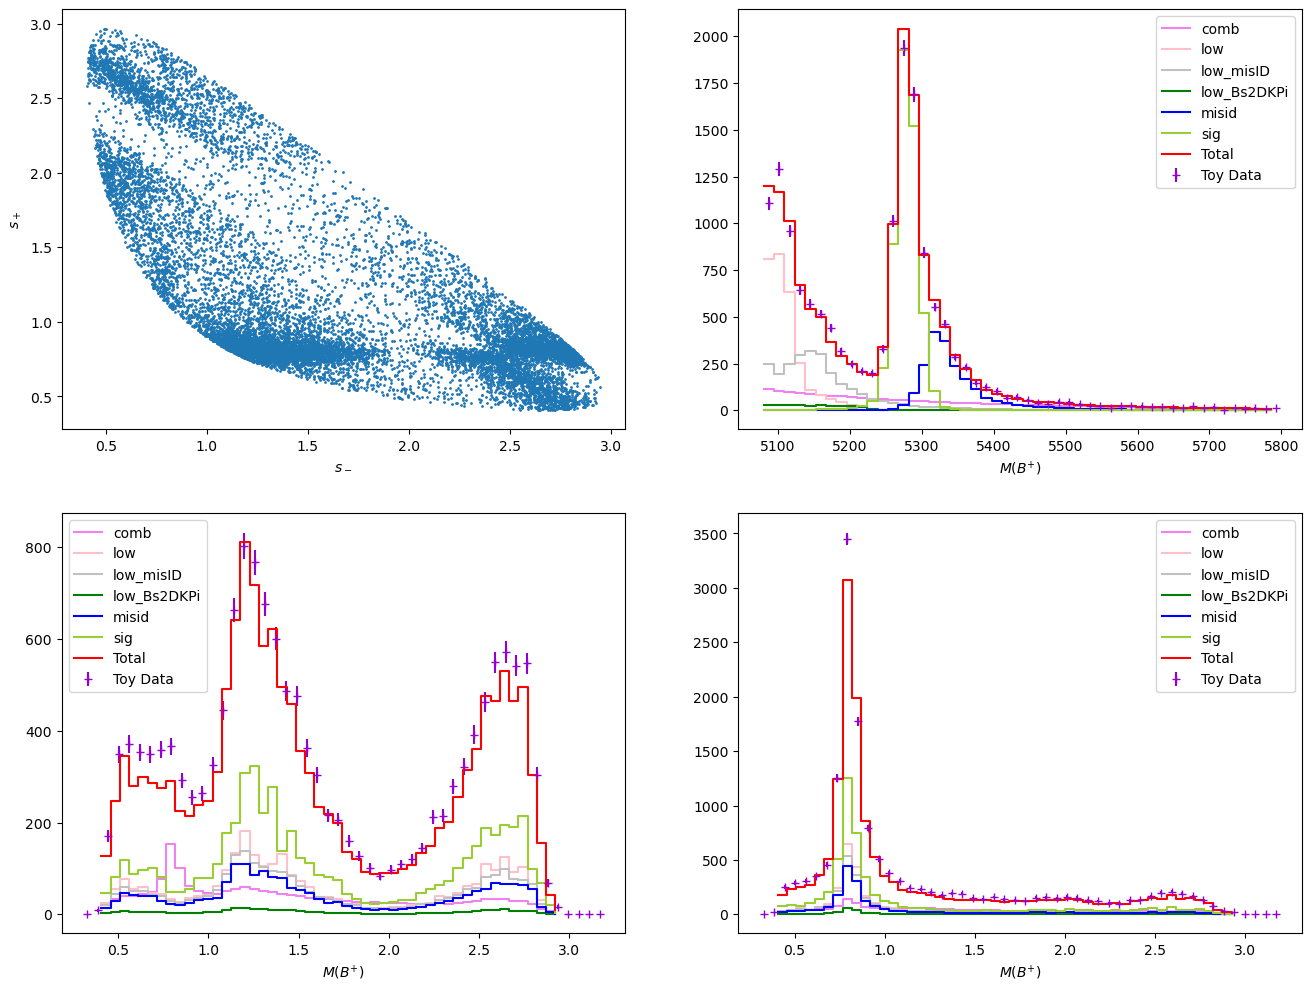

<Figure size 640x480 with 0 Axes>

In [8]:
plot_each('b2dk_DD_p', prob_dk_dd_p)





In [9]:
Bdecays = ['b2dk']#, 'b2dpi']
Types = ['DD']#, 'LL']
for bdecay in Bdecays:
    for Type in Types:
        decay = ''

        if bdecay == 'b2dk':
            decay = 'DK_KsPiPi_%s'%Type
        elif bdecay == 'b2dpi':
            decay = 'DPi_KsPiPi_%s'%Type

        #print yields
        if print_yields == True:
            print('Yields:')
            print('Sig: %.2f'%varDict['n_sig_%s'%decay])
            print('MisID: %.2f'%varDict['n_misid_%s'%decay])
            print('Low: %.2f'%varDict['n_low_%s'%decay])
            print('Comb: %.2f'%varDict['n_comb_%s'%decay])
            if bdecay == 'b2dk':
                print('Low MisID: %.2f'%varDict['n_low_misID_%s'%decay])
                print('Low Bs2DKPi: %.2f'%varDict['n_low_Bs2DKPi_%s'%decay])
                sum_yields = varDict['n_sig_%s'%decay] + varDict['n_misid_%s'%decay] + varDict['n_low_%s'%decay] + varDict['n_comb_%s'%decay] + varDict['n_low_misID_%s'%decay] + varDict['n_low_Bs2DKPi_%s'%decay]
            else:
                sum_yields = varDict['n_sig_%s'%decay] + varDict['n_misid_%s'%decay] + varDict['n_low_%s'%decay] + varDict['n_comb_%s'%decay]
            print('Sum: %.2f'%(int(sum_yields)/2))

Yields:
Sig: 10534.00
MisID: 4008.00
Low: 5772.00
Comb: 3886.00
Low MisID: 5048.00
Low Bs2DKPi: 536.00
Sum: 14892.00


In [20]:
np.min(mass_pdfs['b2dk_DD_p']['sig'].numpy())

4.169784100507733e-07

(array([4954., 4359., 3893., 3517., 3208., 2947., 2727., 2537., 2371.,
        2227., 2098., 1984., 1882., 1789., 1705., 1629., 1560., 1495.,
        1436., 1382., 1332., 1284., 1241., 1199., 1162., 1126., 1091.,
        1061., 1030., 1002.,  975.,  949.,  926.,  902.,  881.,  860.,
         840.,  821.,  803.,  786.,  769.,  753.,  738.,  724.,  709.,
         695.,  683.,  670.,  658.,  647.,  635.,  624.,  614.,  603.,
         594.,  584.,  575.,  566.,  557.,  549.,  541.,  533.,  525.,
         518.,  510.,  503.,  497.,  490.,  483.,  477.,  471.,  465.,
         459.,  453.,  448.,  442.,  437.,  432.,  427.,  422.,  417.,
         412.,  408.,  403.,  399.,  394.,  390.,  386.,  382.,  378.,
         374.,  371.,  367.,  362.,  360.,  356.,  352.,  349.,  346.,
         343.]),
 array([0.00026177, 0.0002999 , 0.00033802, 0.00037615, 0.00041427,
        0.0004524 , 0.00049052, 0.00052864, 0.00056677, 0.00060489,
        0.00064302, 0.00068114, 0.00071927, 0.00075739, 0.00079551

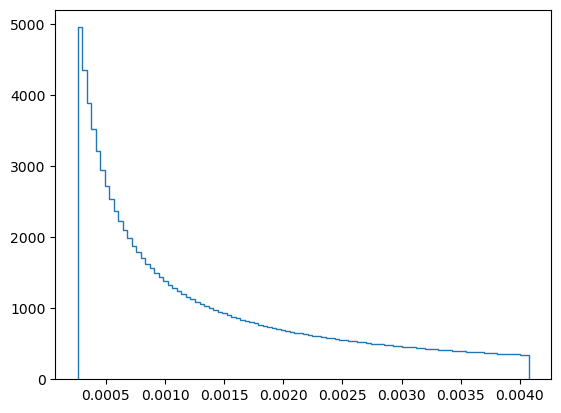

In [18]:
plt.hist(mass_pdfs['b2dk_DD_p']['comb'].numpy(), bins=100, histtype='step')

total yields: 14891.999999999995
total yields: 14891.999999999993
total yields: 14891.99999999999


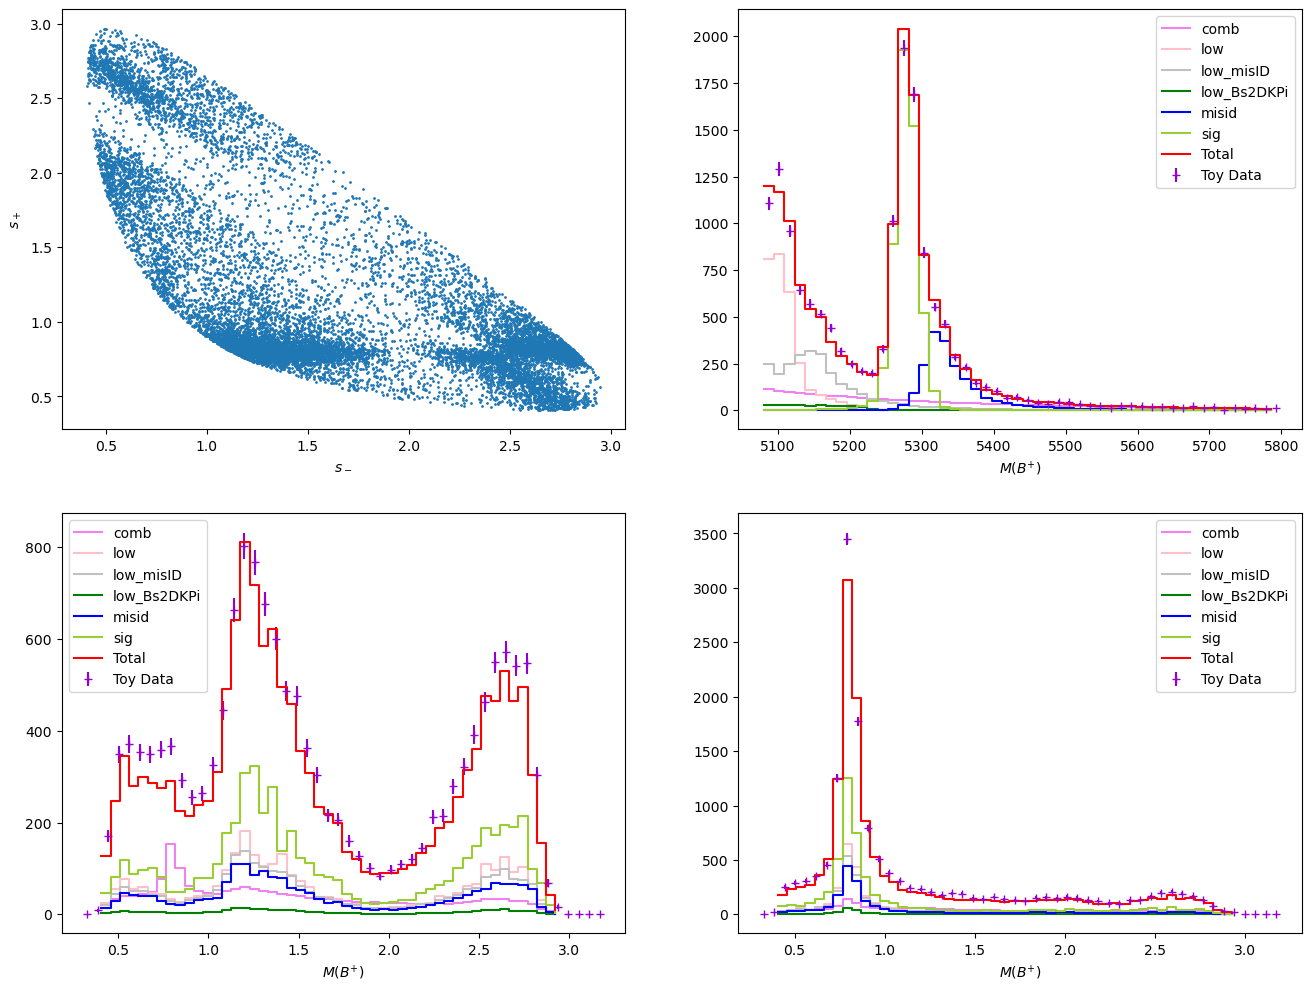

<Figure size 640x480 with 0 Axes>

In [10]:
plot_each('b2dk_DD_p', prob_dk_dd_p)





In [11]:

def prod_nll_dk_dd(x, Bsign=1):

    decay = 'b2dk_DD'
    fracDD = 0.53

    nsig = x[6]*0.5
    nmisid = varDict['n_misid_DK_KsPiPi_DD']*0.5
    ncomb = x[7]*0.5
    nlow = x[8]*0.5
    nlow_misID = varDict['n_low_misID_DK_KsPiPi_DD']*0.5
    nlow_Bs2DKPi = varDict['n_low_Bs2DKPi_DK_KsPiPi_DD']*0.5


    normalisationCrossTerms_p = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_dd_p, ampbar_dk_dd_p)
    normalisationCrossTerms_m = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_dd_m, ampbar_dk_dd_m)
    misid_normalisationCrossTerms_p = totalAmplitudeSquared_Integrated_crossTerm(amp_dpi_dd_p, ampbar_dpi_dd_p)
    misid_normalisationCrossTerms_m = totalAmplitudeSquared_Integrated_crossTerm(amp_dpi_dd_m, ampbar_dpi_dd_m)

    normA_p = tf.math.reduce_mean(tf.math.abs(amp_dk_dd_p)**2*eff[decay+'_p'])
    normAbar_p = tf.math.reduce_mean(tf.math.abs(ampbar_dk_dd_p)**2*eff[decay+'_p'])
    normA_m = tf.math.reduce_mean(tf.math.abs(amp_dk_dd_m)**2*eff[decay+'_m'])
    normAbar_m = tf.math.reduce_mean(tf.math.abs(ampbar_dk_dd_m)**2*eff[decay+'_m'])

    misid_normA_p = tf.math.reduce_mean(tf.math.abs(amp_dpi_dd_p)**2*eff_misid[decay+'_p'])
    misid_normAbar_p = tf.math.reduce_mean(tf.math.abs(ampbar_dpi_dd_p)**2*eff_misid[decay+'_p'])
    misid_normA_m = tf.math.reduce_mean(tf.math.abs(amp_dpi_dd_m)**2*eff_misid[decay+'_m'])
    misid_normAbar_m = tf.math.reduce_mean(tf.math.abs(ampbar_dpi_dd_m)**2*eff_misid[decay+'_m'])


    sig_prob_p = eff[decay+'_p']* nsig * mass_pdfs[decay+'_p']['sig'] * prod_totalAmplitudeSquared_XY(1, amp_dk_dd_p, ampbar_dk_dd_p, x, mass_pdfs[decay+'_p']['sig'], mass_pdfs[decay+'_m']['sig'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    sig_prob_m = eff[decay+'_m']* nsig * mass_pdfs[decay+'_m']['sig'] * prod_totalAmplitudeSquared_XY(-1, amp_dk_dd_m, ampbar_dk_dd_m, x, mass_pdfs[decay+'_p']['sig'], mass_pdfs[decay+'_m']['sig'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    misid_prob_p = eff_misid[decay+'_p'] * nmisid * mass_pdfs[decay+'_p']['misid'] * prod_totalAmplitudeSquared_DPi_XY(1, amp_dk_dd_p, ampbar_dk_dd_p, x, mass_pdfs[decay+'_p']['misid'], mass_pdfs[decay+'_m']['misid'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    misid_prob_m = eff_misid[decay+'_m'] * nmisid * mass_pdfs[decay+'_m']['misid'] * prod_totalAmplitudeSquared_DPi_XY(-1, amp_dk_dd_m, ampbar_dk_dd_m, x, mass_pdfs[decay+'_p']['misid'], mass_pdfs[decay+'_m']['misid'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    comb_prob_p = ncomb * mass_pdfs[decay+'_p']['comb'] * prod_comb(amp_dk_dd_p, ampbar_dk_dd_p, misid_normA_m, misid_normAbar_p, fracDD=fracDD, eff1=eff_low[decay+'_m'], eff2=eff_low[decay+'_p'])
    comb_prob_m = ncomb * mass_pdfs[decay+'_m']['comb'] * prod_comb(amp_dk_dd_m, ampbar_dk_dd_m, misid_normA_m, misid_normAbar_p, fracDD=fracDD, eff1=eff_low[decay+'_m'], eff2=eff_low[decay+'_p'])
    low_prob_p = eff_low[decay+'_p'] * nlow * mass_pdfs[decay+'_p']['low'] * prod_low(1, amp_dk_dd_p, ampbar_dk_dd_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], type='low')
    low_prob_m = eff_low[decay+'_m'] * nlow * mass_pdfs[decay+'_m']['low'] * prod_low(-1, amp_dk_dd_m, ampbar_dk_dd_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], type='low')
    low_misID_prob_p =  eff_low[decay+'_p'] * nlow_misID * mass_pdfs[decay+'_p']['low_misID'] * prod_low(1, amp_dk_dd_p, ampbar_dk_dd_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], type='low_misID')
    low_misID_prob_m =  eff_low[decay+'_m'] * nlow_misID * mass_pdfs[decay+'_m']['low_misID'] * prod_low(-1, amp_dk_dd_m, ampbar_dk_dd_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], type='low_misID')
    low_Bs2DKPi_prob_p = eff_low[decay+'_p'] * nlow_Bs2DKPi * mass_pdfs[decay+'_p']['low_Bs2DKPi'] * prod_low(1, amp_dk_dd_p, ampbar_dk_dd_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], type='low_Bs2DKPi')
    low_Bs2DKPi_prob_m = eff_low[decay+'_m'] * nlow_Bs2DKPi * mass_pdfs[decay+'_m']['low_Bs2DKPi'] * prod_low(-1, amp_dk_dd_m, ampbar_dk_dd_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], type='low_Bs2DKPi')



    total_yield = 1#(nsig + nmisid + ncomb + nlow + nlow_misID + nlow_Bs2DKPi)*2
    
    normalisation_Bplus = totalAmplitudeSquared_Integrated(1, normA_p, normAbar_p, normalisationCrossTerms_p, x)
    normalisation_Bminus = totalAmplitudeSquared_Integrated(-1, normA_m, normAbar_m, normalisationCrossTerms_m, x)
    misid_normalisation_Bplus = totalAmplitudeSquared_DPi_Integrated(1, misid_normA_p, misid_normAbar_p, misid_normalisationCrossTerms_p, x)
    misid_normalisation_Bminus = totalAmplitudeSquared_DPi_Integrated(-1, misid_normA_m, misid_normAbar_m, misid_normalisationCrossTerms_m, x) 


    low_normalisation_Bplus = tf.cast(misid_normAbar_p, tf.float64)
    low_normalisation_Bminus = tf.cast(misid_normA_m, tf.float64)


    prob_p = {}
    prob_m = {}
    prob_p['total'] = (1/total_yield*((sig_prob_p/normalisation_Bplus)+(misid_prob_p/misid_normalisation_Bplus)+(comb_prob_p)+(low_prob_p/low_normalisation_Bplus)+(low_misID_prob_p/low_normalisation_Bplus)+(low_Bs2DKPi_prob_p/low_normalisation_Bplus)))
    prob_m['total'] = (1/total_yield*((sig_prob_m/normalisation_Bminus)+(misid_prob_m/misid_normalisation_Bminus)+(comb_prob_m)+(low_prob_m/low_normalisation_Bminus)+(low_misID_prob_m/low_normalisation_Bminus)+(low_Bs2DKPi_prob_m/low_normalisation_Bminus)))
    prob_p['sig'] = (1/total_yield*((sig_prob_p/normalisation_Bplus)))
    prob_m['sig'] = (1/total_yield*((sig_prob_m/normalisation_Bminus)))
    prob_p['misid'] = (1/total_yield*((misid_prob_p/misid_normalisation_Bplus)))
    prob_m['misid'] = (1/total_yield*((misid_prob_m/misid_normalisation_Bminus)))
    prob_p['comb'] = (1/total_yield*((comb_prob_p)))
    prob_m['comb'] = (1/total_yield*((comb_prob_m)))
    prob_p['low'] = (1/total_yield*((low_prob_p/low_normalisation_Bplus)))
    prob_m['low'] = (1/total_yield*((low_prob_m/low_normalisation_Bminus)))
    prob_p['low_misID'] = (1/total_yield*((low_misID_prob_p/low_normalisation_Bplus)))
    prob_m['low_misID'] = (1/total_yield*((low_misID_prob_m/low_normalisation_Bminus)))
    prob_p['low_Bs2DKPi'] = (1/total_yield*((low_Bs2DKPi_prob_p/low_normalisation_Bplus)))
    prob_m['low_Bs2DKPi'] = (1/total_yield*((low_Bs2DKPi_prob_m/low_normalisation_Bminus)))
                            
    if Bsign ==1:
        return prob_p
    else:
        return prob_m

In [12]:
prob_dk_dd_p = prod_nll_dk_dd(x1, 1)

total yields: 14891.999999999995
total yields: 14891.999999999996
total yields: 14892.000000000004


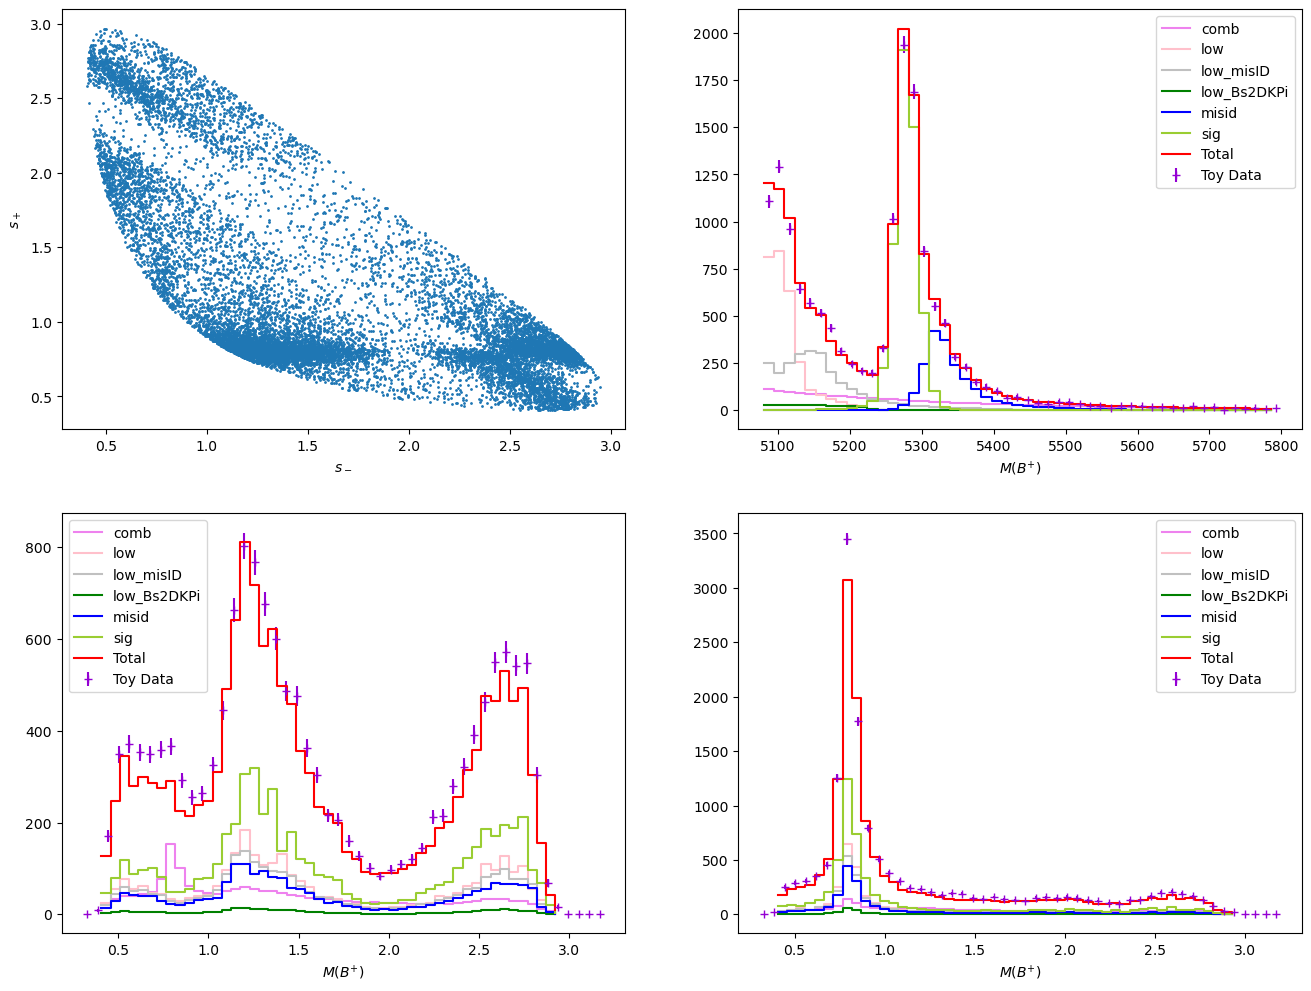

<Figure size 640x480 with 0 Axes>

In [13]:
plot_each('b2dk_DD_p', prob_dk_dd_p)